# On-the-fly simulations in CAR pixelization

We'll now switch to working with maps that are in the Plate-Caree (CAR) projection stored in 2d grids of rectangular pixels. The 2d rectangular aspect allows us to work with maps as numpy arrays, which is especially efficient at storing partial skies. The CAR projection aspect means that spherical harmonic transforms are possible through the ``libsharp`` library.

We use the `pixell` library to work with these maps. Please watch the tutorial on using `pixell` here: https://www.simonsfoundation.org/event/so-theory-tutorial/


In [1]:
# We load the mapsims library as before
import mapsims
# pixell.enmap is for general map manipulation
# pixell.curvedsky is for SHT-related operations
# pixell.utils is for general utilities; we use it for units
# pixell.enplot lets us make high-resolution visualizations of the map using the Python Image Library
from pixell import enmap, curvedsky as cs, utils, enplot
import numpy as np
# We'll use healpy to do an alm -> cl operation
import healpy as hp
import matplotlib.pyplot as plt

## Noise class recap

The core class for noise simulations is `SONoiseSimulator`. It wraps around the SO noise forecast code, which provides noise power spectra (including atmospheric 1/f and white noise) assuming uniform coverage in a specified sky fraction. In addition, it knows about the "hit-count" information for various SO detector tubes (produced by the scan strategy / time domain working groups) through interfaces with remote locations for maps that encode these. It caches these hitmaps locally on disk on first use, and in memory during repeated calls for realizations of the noise.

The hit-counts are used to modulate the SO noise forecast power spectra to produce Gaussian realization maps that are inhomogenous.

Let's examine the class to see how to initialize it:

In [2]:
mapsims.noise.SONoiseSimulator?

Init signature:
mapsims.noise.SONoiseSimulator(
    nside=None,
    shape=None,
    wcs=None,
    ell_max=None,
    return_uK_CMB=True,
    sensitivity_mode='baseline',
    apply_beam_correction=False,
    apply_kludge_correction=True,
    homogeneous=False,
    no_power_below_ell=None,
    rolloff_ell=50,
    survey_efficiency=0.2,
    full_covariance=True,
    LA_years=5,
    LA_noise_model='SOLatV3point1',
    elevation=50,
    SA_years=5,
    SA_one_over_f_mode='pessimistic',
    sky_fraction=None,
    cache_hitmaps=True,
    boolean_sky_fraction=False,
    instrument_parameters='simonsobs_instrument_parameters_2020.06',
)
Docstring:      <no docstring>
Init docstring:
Simulate noise maps for Simons Observatory

Simulate the noise power spectrum in spherical harmonics domain and then generate a map
in microK_CMB or microK_RJ (based on return_uK_CMB)

In the constructor, this object calls the published 20180822 noise simulator and generates
the expected noise power spectra for all c

We see that we need to specify either HEALPIX nside or the shape,wcs pair for a CAR map. Let's request simulated maps with 16 arcmin wide pixels since for this demo we'll work with SAT maps. We ask for our output maps to be projected to a full-sky template with that resolution.

## CAR geometry noise maps

In [3]:
shape,wcs = enmap.fullsky_geometry(res=16.0 * utils.arcmin)
noise_sim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs)

We've instantiated the noise simulator object. The main member function we need is `simulate`, we generates a Gaussian random field with the default inhomogenity and noise power spectra. Let's examine its signature:

In [4]:
noise_sim.simulate?

Signature:
noise_sim.simulate(
    tube,
    output_units='uK_CMB',
    seed=None,
    nsplits=1,
    mask_value=None,
    atmosphere=True,
    hitmap=None,
    white_noise_rms=None,
)
Docstring:
Create a random realization of the noise power spectrum

Parameters
----------

tube : str
    Specify a tube (for SO: ST0-ST3, LT0-LT6) see the `tubes` attribute
output_units : str
    Output unit supported by PySM.units, e.g. uK_CMB or K_RJ
seed : integer or tuple of integers, optional
    Specify a seed. The seed is converted to a tuple if not already
    one and appended to (0,0,6,tube_id) to avoid collisions between
    tubes, with the signal sims and with ACT noise sims, where
    tube_id is the integer ID of the tube.
nsplits : integer, optional
    Number of splits to generate. The splits will have independent noise
    realizations, with noise power scaled by a factor of nsplits, i.e. atmospheric
    noise is assumed to average down with observing time the same way
    the white noise

In [5]:
print(noise_sim.tubes)
print(noise_sim.tubes['ST0'][0].center_frequency)

defaultdict(<class 'list'>, {'LT0': [Channel LT0_UHF1, Channel LT0_UHF2], 'LT1': [Channel LT1_UHF1, Channel LT1_UHF2], 'LT2': [Channel LT2_MFF1, Channel LT2_MFF2], 'LT3': [Channel LT3_MFF1, Channel LT3_MFF2], 'LT4': [Channel LT4_MFS1, Channel LT4_MFS2], 'LT5': [Channel LT5_MFS1, Channel LT5_MFS2], 'LT6': [Channel LT6_LF1, Channel LT6_LF2], 'ST0': [Channel ST0_UHF1, Channel ST0_UHF2], 'ST1': [Channel ST1_MFF1, Channel ST1_MFF2], 'ST2': [Channel ST2_MFS1, Channel ST2_MFS2], 'ST3': [Channel ST3_LF1, Channel ST3_LF2]})
225.7 GHz


We need to specify the name of an SO tube. Let's go with the SAT's ST0 tube. This is a dichroic array containing 150 GHz and 90 GHz channels. We specify a mask value in the unobserved region of zero instead of the default numpy.nan:

In [6]:
tube = 'ST0'
omap = noise_sim.simulate(tube,mask_value=0)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/noise.py:406: UserWarning: WCS of hitmap with nearest pixel-size is not compatible, so interpolating hitmap
  "WCS of hitmap with nearest pixel-size is not compatible, so interpolating hitmap"
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/noise.py:406: UserWarning: WCS of hitmap with nearest pixel-size is not compatible, s

Let's examine the shape and wcs of the returned map:

In [7]:
print(omap.shape)
print(omap.wcs)

(2, 1, 3, 676, 1350)
car:{cdelt:[-0.2667,0.2667],crval:[0.1333,0],crpix:[675.5,339]}


Why is the map 5-dimensional? The dimension convention in this noise generator is:

```
(narray,nsplit,ncomp,Ny,Nx)
```

`Ny` and `Nx` are the usual vertical (declination) and horizontal (RA) pixel lengths of the underlying 2d maps. `ncomp=3` since there are three maps in each array for each of the I,Q,U Stokes components. This code allows us to generate indepndent splits of the map, where each split has `nsplits` larger noise power than specified, with the default being no splitting (`nsplits=1`). Finally, the leading dimensions of the map always have length `narray=2` corresponding to the two correlated dichroic arrays within a tube, in this case the 90 GHz and 150 GHz channels of the LAT's LT3 tube. 

Let's focus on the intensity I of the 90 GHz map, and plot it:

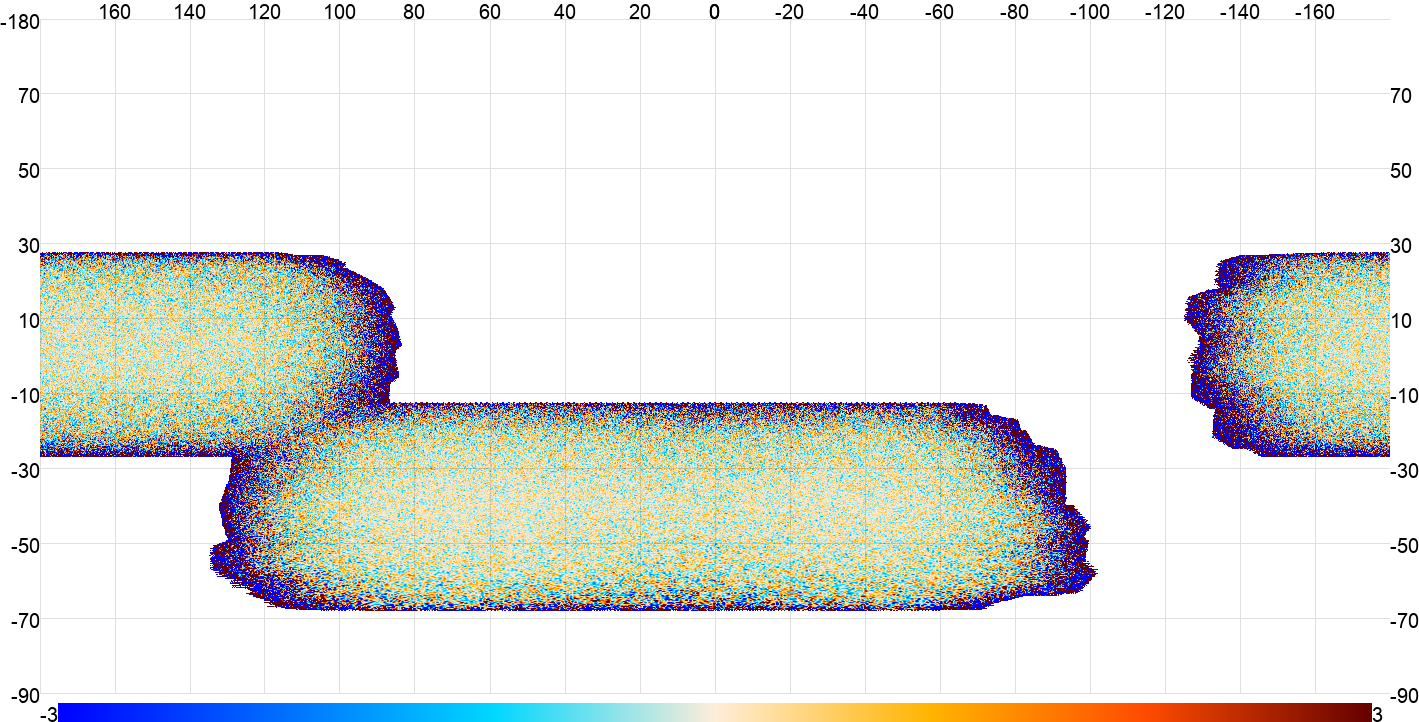

In [8]:
tmap1 = omap[0,0,0]
enplot.show(enplot.plot(tmap1,downgrade=1,grid=True,ticks=20,mask=0,colorbar=True,range=3))

That looks like noise. Noice. It's fairly inhomogeneous, with the noise blowing up near the edges. We don't see any stripiness -- because the SO map-based noise model is too simplistic to capture that! We also find that compared to previous versions of the SO map-based noise sims, we're not just seeing noise modes at the largest scales dominate, since the noise power has been rolled off on large scales to simulate what happens in a realistic map-maker run that doesn't converge fully on the largest scales (and the atmospheric noise doesn't keep arbitrarily increasing anyway).


We also see that we waste quite a lot of space in memory storing all those zero pixels. Let's utilize the cut-sky benefits of working with CAR pixels and define a smaller template limited to the -80 to 30 degree declination region, and re-initialize our noise simulator with that.

In [9]:
shape,wcs = enmap.band_geometry(dec_cut=np.asarray((-80,30))*utils.degree,res=16.0 * utils.arcmin)
noise_sim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs)

In [10]:
omap = noise_sim.simulate(tube,mask_value=0)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/noise.py:406: UserWarning: WCS of hitmap with nearest pixel-size is not compatible, so interpolating hitmap
  "WCS of hitmap with nearest pixel-size is not compatible, so interpolating hitmap"
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/noise.py:406: UserWarning: WCS of hitmap with nearest pixel-size is not compatible, s

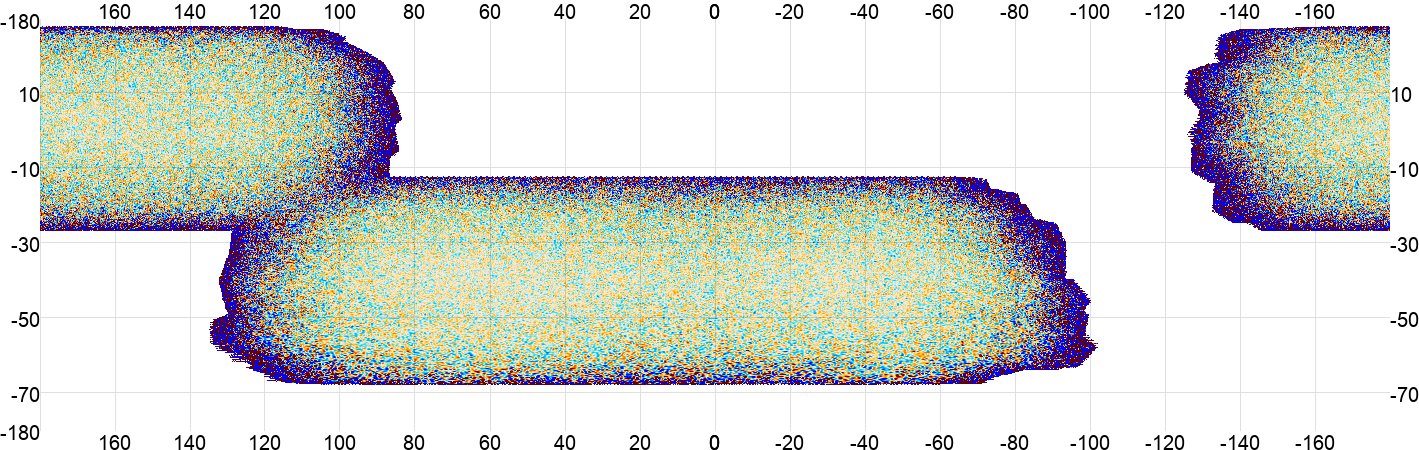

In [11]:
tmap1 = omap[0,0,0]
plot = lambda x,**kwargs: enplot.show(enplot.plot(x,downgrade=1,grid=True,ticks=20,mask=0,**kwargs))
plot(tmap1,range=3)

Ok, that looks a bit tighter -- we're more memory efficient and our SHTs (and iSHT based sim generation) will be faster.



## Understanding the noise model

A very useful auxiliary product to have is the inverse noise variance in each pixel (units 1/muK^2). Let's get that.

In [12]:
ivar = noise_sim.get_inverse_variance(tube)
print(ivar.shape)

(2, 412, 1350)


/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")


In our noise model, all the splits and all the I,Q,U components have the same position dependence of the noise. You just have to keep in mind that each split just has `nsplits` times the noise power (or `1/nsplits` the inverse noise variance) and that the Q,U components have 2x times the noise power (or 1/2 times the inverse noise variance) of the intensity components.

The inverse noise variance provided by the function above is for the `nsplits=1` intensity component. It has two components, one for each of the two correlated arrays in the dichroic tube. We pick the first one, since that's the one corresponding to the map we just simulated:

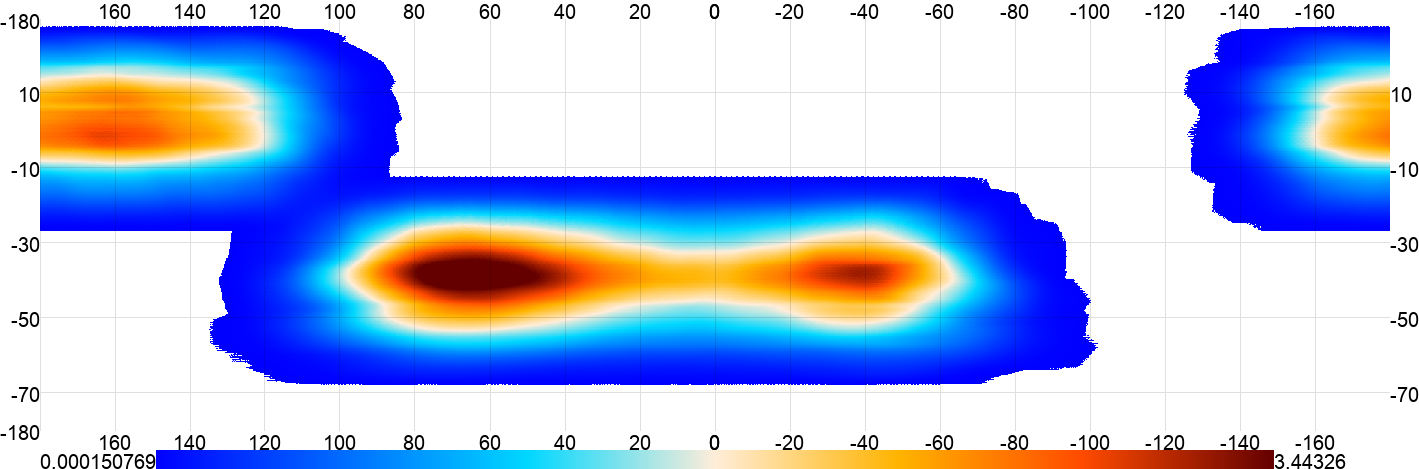

In [13]:
ivar1 = ivar[0]
plot(ivar1,colorbar=True)

And now we see the underlying inhomogenity much better. The inverse noise variance is directly proportional the hit-count maps taken as the input for the noise model. You can clearly see the scan strategy here.

We can use the inverse noise variance map together with the simulated map to verify that our simulations match the input spectra.

The basic idea is that for a simulated map $M$ and inverse noise variance $N^{-1}$, the power spectrum of 

$$
M \sqrt{N^{-1}}
$$

should be identical to the standardized SO noise power spectrum, i.e. the original noise power spectrum but with the white noise power divided out, such that the power spectrum asymptotes to 1 on small scales. This is in fact the *definition* of the noise model we use. You can think of it as standardizing or normalizing the small-scale / high-ell behaviour by dividing the standard deviation, i.e. if our noise model were perfectly homogenous with no 1/f atmospheric component and you divided each pixel by its standard deviation, you would get a white noise power spectrum with value 1. 


So we'll do just that. Multiply our map by the map of the inverse noise variance, take its power spectrum and compare to the input model. We do have to take into account that the inverse noise variance is provided *per pixel* (in units of uK-steradian), so we have to divide out the pixel area. Recall that the CAR pixelization is not equal area, so we need a *map* of the pixel areas. We could get this from `enmap.pixsizemap(shape,wcs)`, but instead we'll just use the pre-calculated one stored in the noise sim generator:

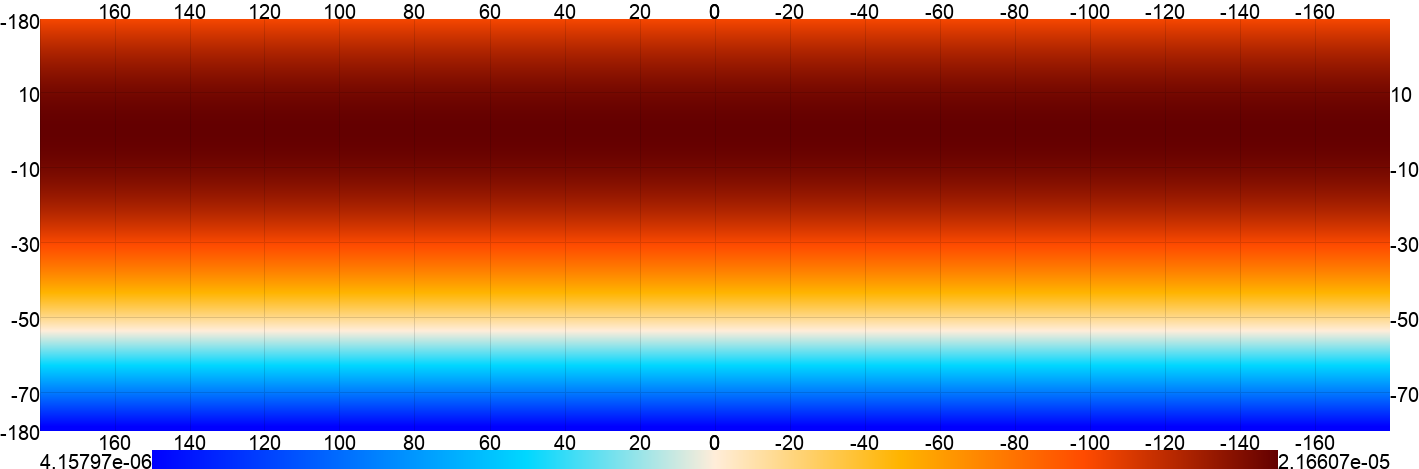

In [14]:
pmap = noise_sim.pixarea_map
plot(pmap,colorbar=True)

Let's plot the standardized map (which should look homogeneous):

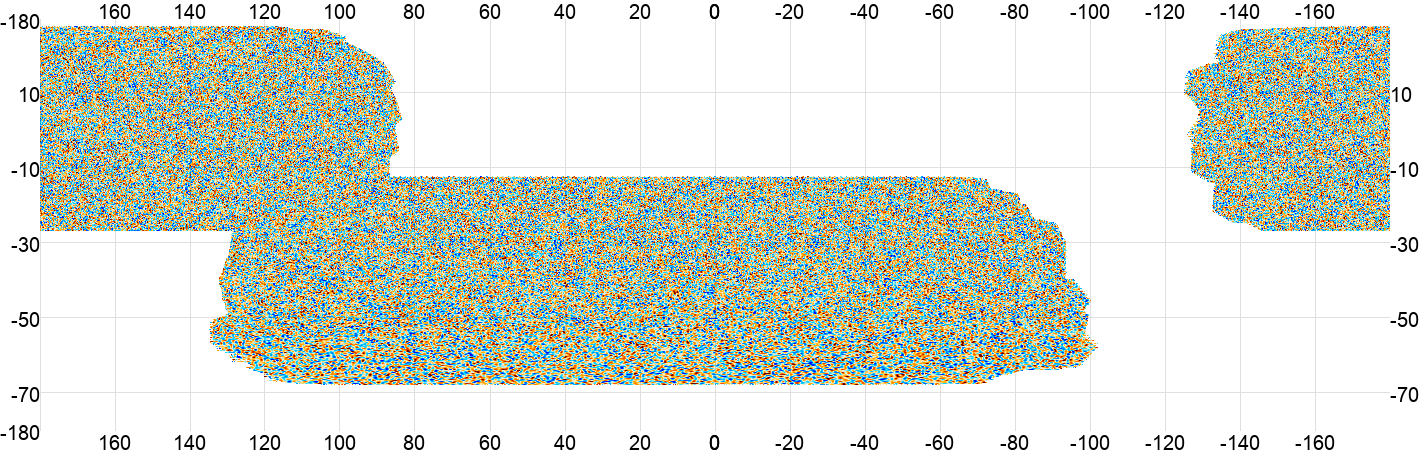

In [15]:
plot(np.sqrt(ivar1/pmap)*tmap1)

Now we calculate the power spectrum of the standardized map, making sure to correct approximately for the incomplete-sky coverage (the correction factor needs to account for the pixel area map too):

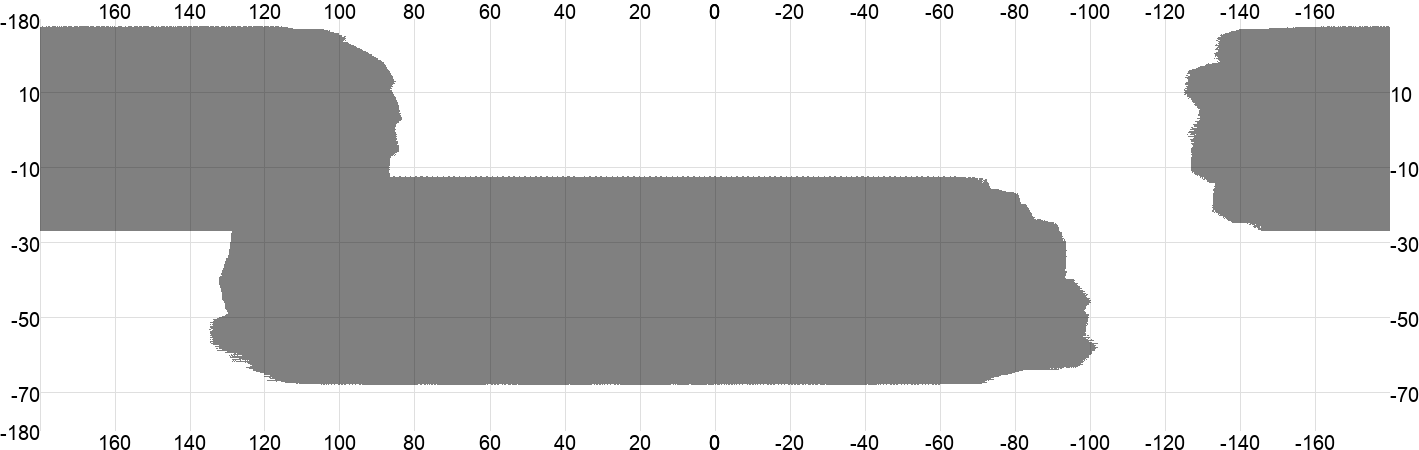

0.3845286320249736


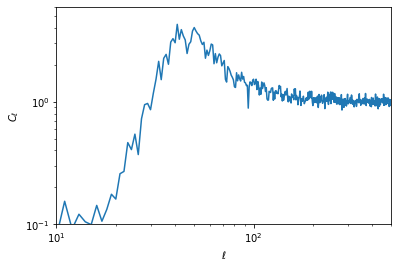

In [16]:
alm = cs.map2alm(np.sqrt(ivar1/pmap)*tmap1,lmax=500)
mask = ivar1*0 + 1
mask[ivar1<=0] = 0
plot(mask,color='gray')
w2 = np.sum((mask**2)*pmap) /np.pi / 4.
print(w2)
cls = hp.alm2cl(alm) / w2
ls = np.arange(cls.size)

plt.plot(ls,cls)
plt.xlabel('$\\ell$')
plt.ylabel('$C_{\\ell}$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-1,6)
plt.xlim(10,500)
plt.show()

How does this compare to the input power spectrum? To check this, we get the input power spectrum from the noise generator object

In [17]:
noise_sim.get_noise_properties?
ells,ps_T,ps_P,fsky,wnoise,hitmaps = noise_sim.get_noise_properties(tube)
print(ps_T.shape)

(3, 625)


/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")


Signature:
noise_sim.get_noise_properties(
    tube,
    nsplits=1,
    hitmap=None,
    white_noise_rms=None,
    atmosphere=True,
)
Docstring:
Get noise curves scaled with the hitmaps and the hitmaps themselves

Parameters
----------
see the docstring of simulate

See the `band_id` attribute of the Channel class
to identify which is the index of a Channel in the returned arrays.

Returns
-------
ell : np.array
    Array of :math:`\ell`
ps_T, ps_P : np.array
    Tube noise spectra for T and P, one row per channel, the 3rd the crosscorrelation
fsky : np.array
    Array of sky fractions computed as <normalized N_hits>
wnoise_power : np.array
    White noise power (high-ell limit)
hitmaps : np.array
    Array of the hitmaps for each channel
File:      /global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/noise.py
Type:      method


and plot it dividing out the white noise level

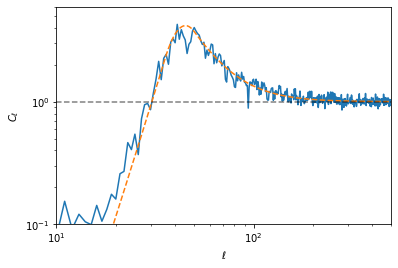

In [18]:
plt.plot(ls,cls)
plt.plot(ells,ps_T[0]/wnoise[0],ls='--')
plt.axhline(y=1,color='k',ls='--',alpha=0.5)
plt.xlabel('$\\ell$')
plt.ylabel('$C_{\\ell}$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-1,6)
plt.xlim(10,500)
plt.show()

## Simplifying the noise model (e.g. for controlled tests)

We can turn off the 1/f (atmosphere):

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/car/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap_CAR_12.00_arcmin.fits.gz
  warnings.warn(f"Access data from {full_path}")


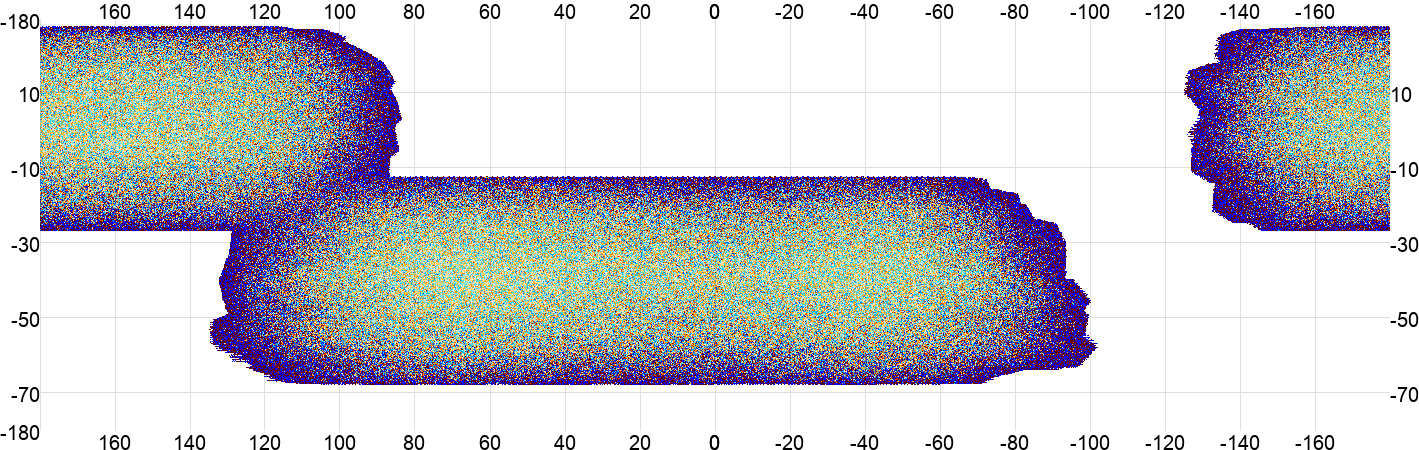

In [19]:
omap = noise_sim.simulate(tube,mask_value=0,atmosphere=False)
plot(omap[0][0][0],range=2)

Or ask for a homogenous map (no survey strategy or hitmap):

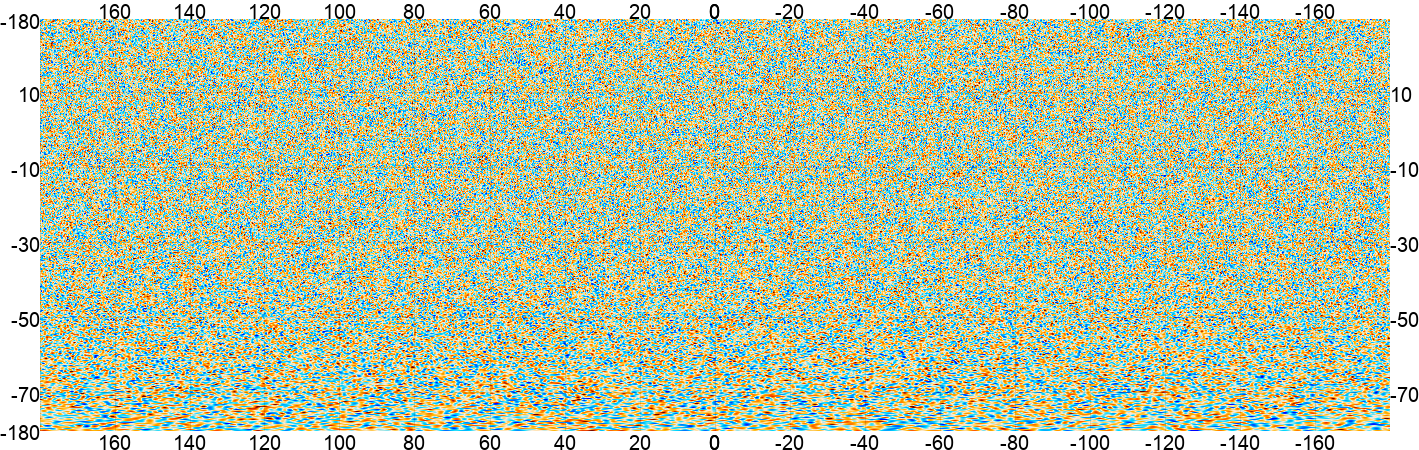

In [20]:
noise_sim = mapsims.noise.SONoiseSimulator(shape=shape,wcs=wcs,homogeneous=True,sky_fraction=0.4)
omap = noise_sim.simulate(tube,mask_value=0)
plot(omap[0][0][0],range=2)

## CMB signal sims in CAR on-the-fly

We've seen how to load saved CMB sims from disk. Here's how to alm->map them on the fly for seed number ``num``:

In [21]:
shape,wcs = enmap.band_geometry(np.asarray((-20,20))*utils.degree,res=4.*utils.arcmin)
ssim = mapsims.SOStandalonePrecomputedCMB(num=0,shape=shape,wcs=wcs)

In [22]:
ch = noise_sim.tubes['LT3'][0] # get the channel corresponding to the first array in the tube
omap = enmap.enmap(ssim.simulate(ch),wcs)

Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Allocating shape (3, 600, 5400) dtype d intermediate map
Performing alm2map


(3, 600, 5400) car:{cdelt:[-0.06667,0.06667],crval:[0.03333,0],crpix:[2700,301]}


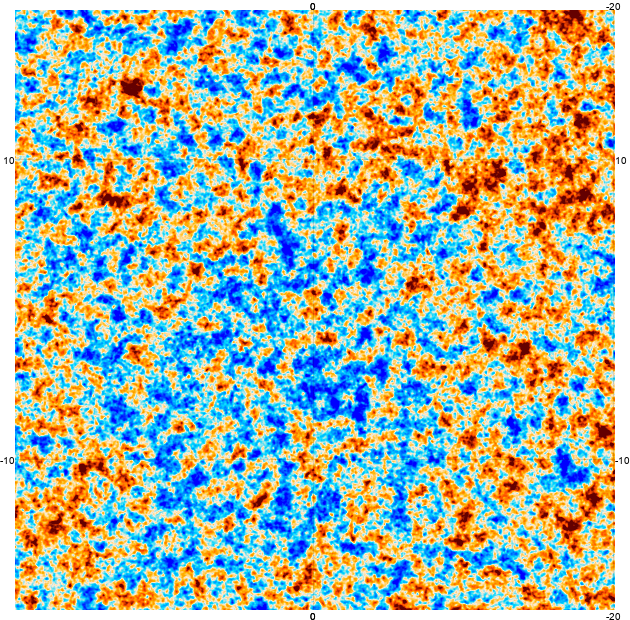

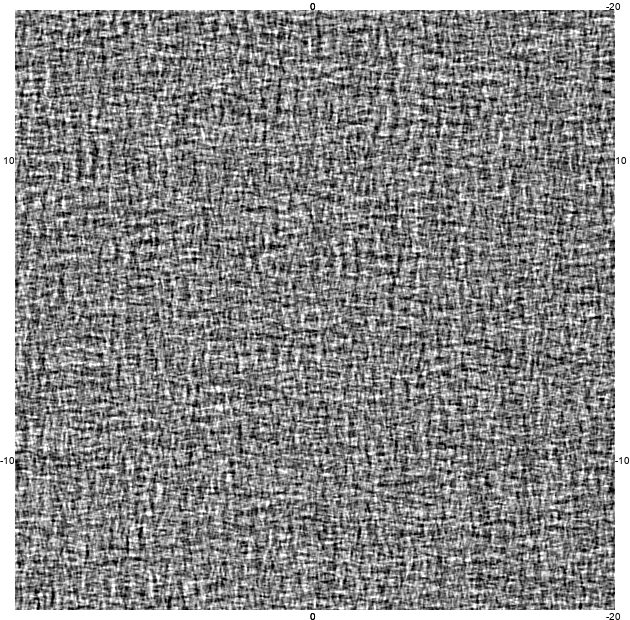

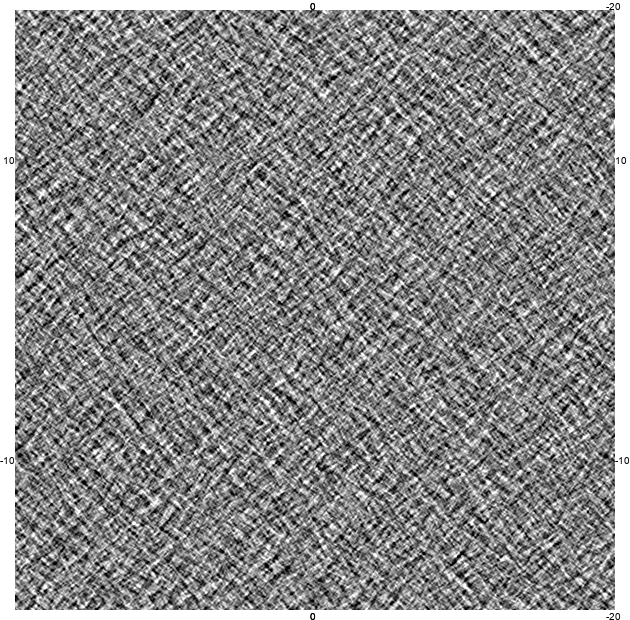

In [23]:
print(omap.shape,omap.wcs)
for i in range(3): 
    box = np.asarray([[-20,-20],[20,20]]) * utils.degree
    plot(omap[i].submap(box),font_size=10,color='planck' if i==0 else 'gray')